# Part 2C - NLP EDA of Amazon Reviews for Miracle Noodles (In-Depth)

## Introduction

Latent Dirichlet Allocation (LDA) is a powerful technique for topic modeling, which helps uncover the underlying themes within a large collection of text. In this notebook, we apply LDA topic modeling to analyze Amazon reviews for the "Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair" product. By doing so, we aim to discover and interpret the main topics discussed in both high and low-rating reviews, providing valuable insights into customer preferences and issues.

#### Objectives

1. **Preprocess Text Data**:
   - Clean and prepare the text data by tokenizing, removing stopwords, and lemmatizing the reviews.
   - Generate multiple versions of the text data for analysis.

2. **Build LDA Models**:
   - Create dictionaries and corpora for high and low-rating reviews.
   - Build and train LDA models to uncover latent topics in the text data.
   - Set the number of topics to 5 for both high and low-rating reviews.

3. **Visualize and Interpret Topics**:
   - Print and analyze the topics generated by the LDA models.
   - Create interactive visualizations using `pyLDAvis` to explore and interpret the discovered topics.
   - Explain the main components of the LDA visualization and how to use the relevance metric slider for deeper analysis.

4. **Save and Display Results**:
   - Save the processed data and visualizations in various formats for future use.
   - Provide clear instructions and explanations to guide users in interpreting the topics and visualizations.

5. **Sentiment Analysis with VADER**: 
   - Apply VADER sentiment analysis to create polarity scores for the reviews.
   - Compare the sentiments of high-rating and low-rating reviews.
   - Analyze the average sentiment scores for high and low-rating reviews and identify any discrepancies.

By the end of this notebook, we will have a comprehensive understanding of the main themes present in high and low-rating reviews, helping us draw actionable insights to improve the product and enhance customer satisfaction.


In [179]:
import json
# Load the filepaths.json dictionary
FPATHS_FILE = "config/filepaths.json"

with open(FPATHS_FILE) as f:
    FPATHS = json.load(f)
FPATHS.keys()

dict_keys(['data', 'images', 'metadata', 'eda', 'models', 'results', 'readme'])

In this notebook we will continue with the data we prepared in the last notebook.  
Our goals will be:
- compare sentiment analysis from VADER / TextBlob vs. the star rating.
- Apply LDA topic modeling to the reviews to idntify consistent themes. 
- Applied Named Entity Recognition to see if an NE's appear in certain types of reviws.

In [180]:
from IPython.display import display, Markdown
with open("data/Amazon Product Reviews.md") as f:
    info = f.read()

display(Markdown(info))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

## Code

In [181]:
# !pip install -U dojo_ds -q
import dojo_ds as ds
# ds.__version__

In [182]:
import matplotlib.pyplot as plt
import missingno
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import os, json
from pprint import pprint
pd.set_option("display.max_columns",50)
pd.set_option('display.max_colwidth', 250)

import spacy



In [183]:
# print)
FPATHS['data'].keys()

dict_keys(['raw', 'cleaned', 'subset', 'processed-nlp', 'app', 'ml-nlp', 'nn-nlp'])

In [184]:
FPATHS['data']['processed-nlp']

{'processed-reviews-spacy_json': 'data/processed/processed-reviews.json',
 'processed-reviews-spacy_joblib': 'data/processed/processed-reviews.joblib',
 'processed-reviews-with-target_json': 'data/processed/processed-reviews-with-target.json',
 'processed-reviews-with-target_joblib': 'data/processed/processed-reviews-with-target.joblib'}

In [185]:
# FPATHS['data']['ml-nlp']

In [186]:
# Fpath for saving final df with target columns
fpath_out_ml_with_targets = FPATHS['data']['processed-nlp']['processed-reviews-with-target_json']
fpath_out_ml_with_targets

'data/processed/processed-reviews-with-target.json'

In [187]:
## If using json
reviews_fpath = FPATHS['data']['processed-nlp']['processed-reviews-spacy_json']
reviews_fpath

'data/processed/processed-reviews.json'

In [188]:
# Load the reviews  data
df = pd.read_json(reviews_fpath)
# df = df.reset_index(drop=False)
df.head(3)

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in the packaged is SKRONG!",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","[four, stars, great, pasta, taste, and, feel, but, the, spell, in, the, packaged, is, skrong]","[stars, great, pasta, taste, feel, spell, packaged, skrong]","[star, great, pasta, taste, feel, spell, package, skrong]",four stars great pasta taste and feel but the spell in the packaged is skrong,stars great pasta taste feel spell packaged skrong,star great pasta taste feel spell package skrong
1,B007JINB0W,A3D7EFSRC6Y9MP,"The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.",Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","[okay, but, do, n't, like, texture, the, texture, just, made, it, a, little, strange, to, eat, otherwise, the, flavor, is, okay, very, bland, so, add, spices]","[okay, like, texture, texture, little, strange, eat, flavor, okay, bland, add, spices]","[okay, like, texture, texture, little, strange, eat, flavor, okay, bland, add, spice]",okay but do n't like texture the texture just made it a little strange to eat otherwise the flavor is okay very bland so add spices,okay like texture texture little strange eat flavor okay bland add spices,okay like texture texture little strange eat flavor okay bland add spice
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,"[go, for, the, green, noodles, the, herb, flavor, makes, the, odd, texture, of, shirataki, much, more, palatable]","[green, noodles, herb, flavor, makes, odd, texture, shirataki, palatable]","[green, noodle, herb, flavor, make, odd, texture, shirataki, palatable]",go for the green noodles the herb flavor makes the odd texture of shirataki much more palatable,green noodles herb flavor makes odd texture shirataki palatable,green noodle herb flavor make odd texture shirataki palatable


In [189]:
# Check for duplciate review ids
dup_subset_cols = ['asin','reviewerID','review-text-full']
df.duplicated(subset=dup_subset_cols).sum()

0

In [190]:
# Check for duplicated review text
df.duplicated(subset=['review-text-full']).sum()

42

In [191]:
df.isna().sum()

asin                    0
reviewerID              0
reviewText              0
summary                 0
overall                 0
year                    0
title                   0
brand                   0
category                0
review-text-full        0
review-text-full_raw    0
tokens-dirty            0
tokens                  0
lemmas                  0
tokens-dirty-joined     0
tokens-joined           0
lemmas-joined           0
dtype: int64

<Axes: >

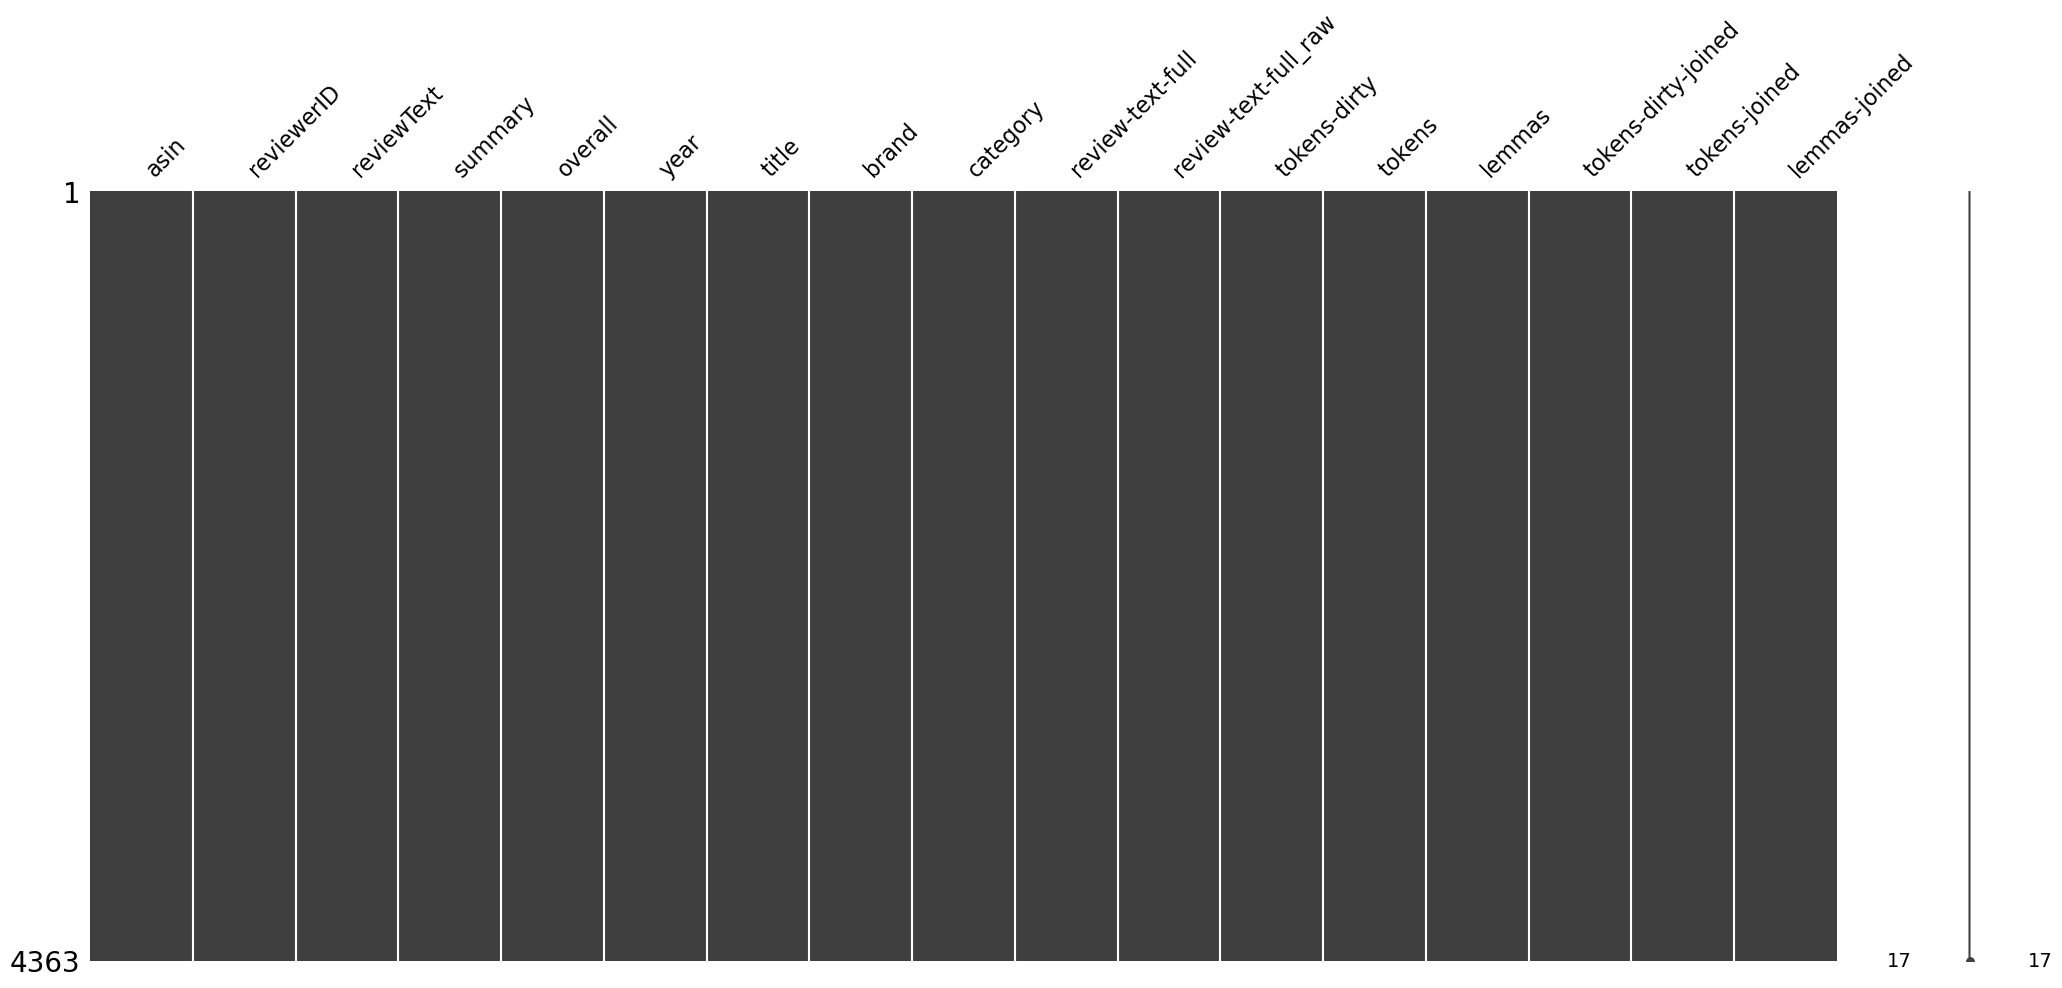

In [192]:
import missingno
missingno.matrix(df)

## Set Groups (for EDA & Modeling)

In [193]:
# Set color palette
palette_tab10 = sns.palettes.color_palette('tab10',n_colors=len(df['overall'].unique()))
palette_tab10

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

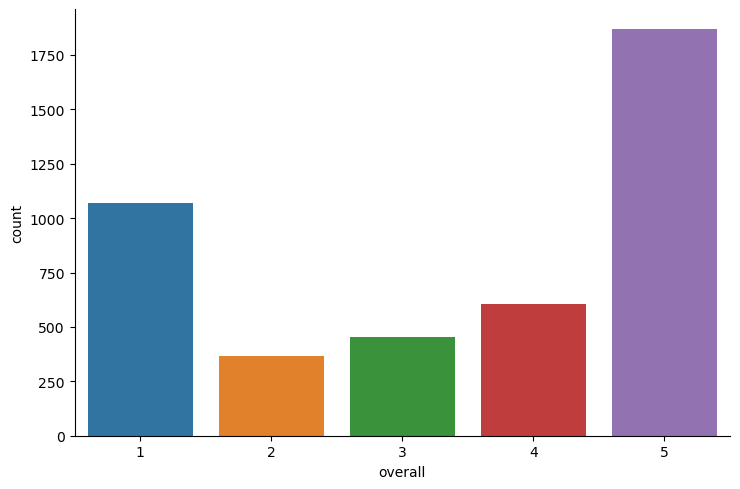

In [194]:
ax = sns.catplot(data=df,x='overall',kind='count', aspect=1.5, hue="overall",
            palette=palette_tab10,legend=False)

To understand what customers do and do not like about Hoover products, we will define 2 groups:
- High Ratings
    - Overall rating = 5.0
- Low Ratings
    - Overall rating = 1.0 or 2.0


We can use a function and .map to define group names based on the numeric overall ratings.

### Define Target Groups (02/08)

Binary:
- "High Rating": = 5
- "Low Rating": <= 2
<!-- 
Multiclass:
- "High Rating": >= 8
- "Mid Rating": 4< x < 8
- "Low Rating": <4 -->

In [195]:
def create_groups(x):
    if x>=5.0:
        return "High"
    elif x <=2.0:
        return "Low"
    else: 
        return None
    

# def set_groups_multi(x):
#     if x >= 8:
#         group = "High"
#     elif x>=4:
#         group = "Mid"
#     else:
#         group= "Low"
#     return group

In [196]:
# Set target column
df['target-rating'] = df['overall'].map(create_groups)#set_group_binary)
df['target-rating'].value_counts(dropna=False)

target-rating
High    1868
Low     1437
None    1058
Name: count, dtype: int64

### Class Balance

It's always a good idea to check the class balance when creating a classification model.  This can affect modeling bias and interpretation of metrics.

In [197]:
df['target-rating'].value_counts(dropna=True, normalize=True)

target-rating
High    0.565204
Low     0.434796
Name: proportion, dtype: float64

In [198]:
FPATHS['eda']['class_balance']['class-balance_png']

'eda/class-balance.png'

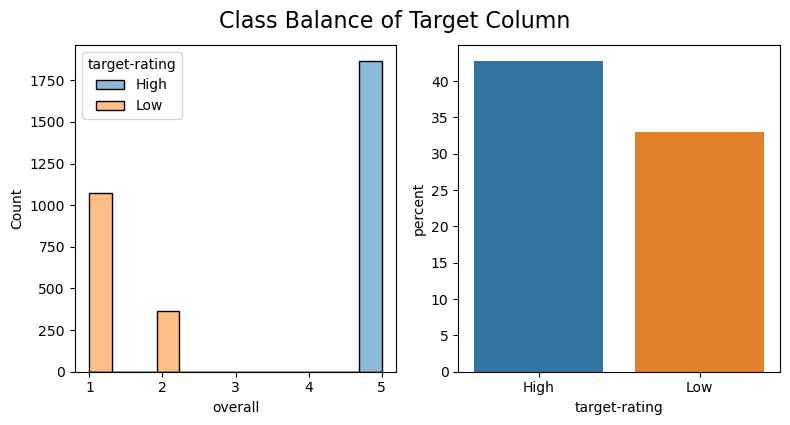

In [199]:
fig, axes =  plt.subplots(ncols=2, figsize=(8,4))
sns.histplot(data=df, x='overall', hue='target-rating', ax=axes[0])
sns.countplot(data=df, x='target-rating', hue='target-rating', ax=axes[1], legend=False, stat='percent')
fig.tight_layout()
fig.suptitle('Class Balance of Target Column', y=1.05, fontsize=16)

fig.savefig(FPATHS['eda']['class_balance']['class-balance_png'], transparent=False, bbox_inches='tight', dpi=300)

#### Save Reviews with Target for Modeling (Part 3)

In [200]:
df.head(3)

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in the packaged is SKRONG!",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","[four, stars, great, pasta, taste, and, feel, but, the, spell, in, the, packaged, is, skrong]","[stars, great, pasta, taste, feel, spell, packaged, skrong]","[star, great, pasta, taste, feel, spell, package, skrong]",four stars great pasta taste and feel but the spell in the packaged is skrong,stars great pasta taste feel spell packaged skrong,star great pasta taste feel spell package skrong,None
1,B007JINB0W,A3D7EFSRC6Y9MP,"The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.",Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","[okay, but, do, n't, like, texture, the, texture, just, made, it, a, little, strange, to, eat, otherwise, the, flavor, is, okay, very, bland, so, add, spices]","[okay, like, texture, texture, little, strange, eat, flavor, okay, bland, add, spices]","[okay, like, texture, texture, little, strange, eat, flavor, okay, bland, add, spice]",okay but do n't like texture the texture just made it a little strange to eat otherwise the flavor is okay very bland so add spices,okay like texture texture little strange eat flavor okay bland add spices,okay like texture texture little strange eat flavor okay bland add spice,None
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,"[go, for, the, green, noodles, the, herb, flavor, makes, the, odd, texture, of, shirataki, much, more, palatable]","[green, noodles, herb, flavor, makes, odd, texture, shirataki, palatable]","[green, noodle, herb, flavor, make, odd, texture, shirataki, palatable]",go for the green noodles the herb flavor makes the odd texture of shirataki much more palatable,green noodles herb flavor makes odd texture shirataki palatable,green noodle herb flavor make odd texture shirataki palatable,High


In [201]:
# Save the df with target columns
fpath_out_ml_with_targets =  FPATHS['data']['processed-nlp']['processed-reviews-with-target_json']
fpath_out_ml_with_targets

'data/processed/processed-reviews-with-target.json'

In [202]:
# Checking filepaths 
FPATHS['data']['processed-nlp']

{'processed-reviews-spacy_json': 'data/processed/processed-reviews.json',
 'processed-reviews-spacy_joblib': 'data/processed/processed-reviews.joblib',
 'processed-reviews-with-target_json': 'data/processed/processed-reviews-with-target.json',
 'processed-reviews-with-target_joblib': 'data/processed/processed-reviews-with-target.joblib'}

In [203]:
# Save to json
df.to_json(fpath_out_ml_with_targets)

In [204]:
# Test saved json file
pd.read_json(fpath_out_ml_with_targets).head(3)

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in the packaged is SKRONG!",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","[four, stars, great, pasta, taste, and, feel, but, the, spell, in, the, packaged, is, skrong]","[stars, great, pasta, taste, feel, spell, packaged, skrong]","[star, great, pasta, taste, feel, spell, package, skrong]",four stars great pasta taste and feel but the spell in the packaged is skrong,stars great pasta taste feel spell packaged skrong,star great pasta taste feel spell package skrong,None
1,B007JINB0W,A3D7EFSRC6Y9MP,"The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.",Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","[okay, but, do, n't, like, texture, the, texture, just, made, it, a, little, strange, to, eat, otherwise, the, flavor, is, okay, very, bland, so, add, spices]","[okay, like, texture, texture, little, strange, eat, flavor, okay, bland, add, spices]","[okay, like, texture, texture, little, strange, eat, flavor, okay, bland, add, spice]",okay but do n't like texture the texture just made it a little strange to eat otherwise the flavor is okay very bland so add spices,okay like texture texture little strange eat flavor okay bland add spices,okay like texture texture little strange eat flavor okay bland add spice,None
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,"[go, for, the, green, noodles, the, herb, flavor, makes, the, odd, texture, of, shirataki, much, more, palatable]","[green, noodles, herb, flavor, makes, odd, texture, shirataki, palatable]","[green, noodle, herb, flavor, make, odd, texture, shirataki, palatable]",go for the green noodles the herb flavor makes the odd texture of shirataki much more palatable,green noodles herb flavor makes odd texture shirataki palatable,green noodle herb flavor make odd texture shirataki palatable,High


In [205]:
# Checking filepath
FPATHS['data']['processed-nlp']['processed-reviews-with-target_joblib']

'data/processed/processed-reviews-with-target.joblib'

In [206]:
import joblib
# Saving processed reviews with target column
joblib.dump(df, FPATHS['data']['processed-nlp']['processed-reviews-with-target_joblib'],compress=9)

['data/processed/processed-reviews-with-target.joblib']

In [207]:
# Saving MVP test case 
mvp_cols = ['reviewerID','review-text-full',
            'overall',
            'target-rating']
df[mvp_cols]

,reviewerID,review-text-full,overall,target-rating
0,A3Y51NV9HU5T2,"Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!",4,None
1,A3D7EFSRC6Y9MP,"Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.",3,None
2,A4AM5KBP3I2R,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,5,High
3,A3GHK4IL78DB7Y,Its an awesome substitute.: I didn't have a problem at all with a half filled bag or anything that other users said. I was concerned at first but I took a chance and there were no problems.\nI find the best way to get rid of the initial smell is ...,5,High
4,AH3B94LQOPPY6,Five Stars: They taste like whatever you cook them with.,5,High
...,...,...,...,...
4358,A73IG1ED6S0JR,would not recomend: Product arrived with two of the bags punctured. Also smells really really bad.,1,Low
4359,A1XZ2H0MYG54M0,Five Stars: Ok.,5,High
4360,A3I2YF0MXB7P0B,"Not awful, but now I know why these were on sale.: I like these noodles but the spinach ones just taste odd. They have a bitter flavor compared to the other ones. I don't think it tastes like Spinach, it just tastes bitter and odd. Now I understa...",2,Low
4361,A2UELLFLITPMT1,Don't even try it.: Truly horrific. Like eating dead worms.,1,Low


In [208]:
# Save MVP data for LLM
fpath_llm = FPATHS['data']['app']['reviews-with-target-for-llm_csv']
df[mvp_cols].to_csv(fpath_llm, index=False)

# Part 2C) EDA and Visualization

**2) EDA and Visualization:**

- Apply LDA topic modeling to each group separately.
    - Use top 10 words per topic with ChatGPT to get the label and interpretation of each topic.


- Perform sentiment analysis to create polarity scores according to VADERS's sentiment lexicon.

    - Compare the sentiments of high-rating and low-rating texts.

    - Compare the average sentiment scores for high and low-rating reviews.

    - Which review polarity scores don't match the ratings? Why do you think this is?


## Topic Analysis

### Introduction to LDA Topic Modeling



Latent Dirichlet Allocation (LDA) is a powerful unsupervised machine learning technique commonly used for topic modeling in natural language processing (NLP). This method helps uncover the underlying topics present within a large collection of documents by identifying patterns in the word usage. 

#### Why LDA?

1. **Identifying Themes**: LDA helps in automatically discovering the hidden thematic structure in a corpus of text. This can be particularly useful for understanding large datasets of textual information without having to manually read through every document.
2. **Dimensionality Reduction**: By representing documents as mixtures of topics, LDA effectively reduces the dimensionality of text data, making it easier to analyze and visualize.
3. **Informing Decision Making**: Understanding the main topics in customer reviews, articles, or any other textual data can provide valuable insights for decision-making, trend analysis, and strategic planning.

#### How LDA Works

LDA assumes that each document is a mixture of several topics, and each topic is a mixture of words. The goal is to infer these mixtures from the observed data (i.e., the words in the documents). The key steps involved in applying LDA are:

1. **Tokenization**: Breaking down the text into individual words or tokens.
2. **Preprocessing**: Cleaning the text data by removing stop words, punctuation, and applying techniques like lemmatization.
3. **Modeling**: Using the LDA algorithm to discover the latent topics in the text.
4. **Visualization**: Interpreting the results by visualizing the topics and their most relevant terms.

In this section, we will apply LDA topic modeling to our dataset of reviews. This involves the following steps:

1. **Preprocessing the Text Data**: We will start by cleaning and preparing the text data for analysis.
2. **Building the LDA Model**: Using the preprocessed data, we will build an LDA model to uncover the latent topics.
3. **Visualizing the Topics**: Finally, we will use interactive visualizations to explore and interpret the discovered topics.

By the end of this section, you will have a clear understanding of the main themes present in the reviews and how they contribute to the overall structure of the dataset. This will provide valuable insights that can inform future analysis and decision-making.

### Step 1: Preprocess the Text Data (Lemmas)

In [209]:
# Loading spacy for preprocess
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser','ner'])
nlp

In [210]:
# Reviewing which column to use 
df['review-text-full'].head(3)

0                                                          Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!
1    Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.
2                                         Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.
Name: review-text-full, dtype: object

In [211]:
def preprocess(text):
    """
    Preprocesses the given text by performing the following steps:
    1. If the input is not an instance of `spacy.tokens.Doc`, it is converted to a `Doc` object using `nlp` (assuming `nlp` is defined elsewhere).
    2. Lemmatizes each token in the `Doc` object.
    3. Removes stop words and tokens with a length less than or equal to 3.
    
    Args:
        text (str or spacy.tokens.Doc): The text to be preprocessed.
        
    Returns:
        list: A list of lemmatized tokens after removing stop words and tokens with a length less than or equal to 3.
    """
    if isinstance(text, spacy.tokens.Doc)==False:
        doc = nlp(text)
    else:
        doc = text
    result = [token.lemma_ for token in doc if not token.is_stop and len(token) > 3]
    return result

In [212]:
# Preprocess the text
lemmas = []
for doc in  nlp.pipe(df['review-text-full'], batch_size=100, n_process=-1):
    lemmas.append(preprocess(doc))
    
print(f"{len(lemmas)=}, {len(df['review-text-full'])=}")
df['lemmas'] = lemmas
df['lemmas'].head()

len(lemmas)=4363, len(df['review-text-full'])=4363


0                                                                                                                                [star, great, pasta, taste, feel, spell, package, SKRONG]
1                                                                                                              [okay, like, texture, texture, little, strange, flavor, okay, bland, spice]
2                                                                                                                       [green, noodle, herb, flavor, make, texture, shirataki, palatable]
3    [awesome, substitute, problem, half, fill, user, say, concern, take, chance, problem, find, good, initial, smell, boil, cube, bouillon, texture, good, notice, replace, noodle, mind]
4                                                                                                                                                                [star, taste, like, cook]
Name: lemmas, dtype: object

### Step 2: Build the LDA Model


> Needed to install `pip install scipy==1.10.1` due to triu missing from scipy error.


In [213]:
import gensim
import  scipy
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim import corpora


print(f"{gensim.__version__=}, {scipy.__version__=}")

gensim.__version__='4.3.2', scipy.__version__='1.10.1'


In [214]:
# Separate group
high_reviews = df.loc[df['target-rating']=='High','lemmas']
low_reviews = df.loc[df['target-rating']=='Low','lemmas']

# Create dictionary and corpus for high-rating reviews
high_dictionary = corpora.Dictionary(high_reviews)
high_corpus = [high_dictionary.doc2bow(text) for text in high_reviews]

# Create dictionary and corpus for low-rating reviews
low_dictionary = corpora.Dictionary(low_reviews)
low_corpus = [low_dictionary.doc2bow(text) for text in low_reviews]


In [215]:
# Number of topics
num_topics = 5

# LDA model for high-rating reviews
high_lda = LdaModel(high_corpus, num_topics=num_topics, id2word=high_dictionary, passes=15)

# LDA model for low-rating reviews
low_lda = LdaModel(low_corpus, num_topics=num_topics, id2word=low_dictionary, passes=15)

In [216]:
# Print the topics for high-rating reviews
print("High Rating Reviews Topics:")
for idx, topic in high_lda.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}")

# Print the topics for low-rating reviews
print("Low Rating Reviews Topics:")
for idx, topic in low_lda.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}")

High Rating Reviews Topics:
Topic: 0 
Words: 0.036*"rice" + 0.033*"noodle" + 0.022*"pasta" + 0.020*"like" + 0.019*"carb" + 0.014*"rinse" + 0.012*"good" + 0.012*"dish" + 0.012*"sauce" + 0.011*"love"
Topic: 1 
Words: 0.039*"noodle" + 0.029*"like" + 0.018*"pasta" + 0.017*"smell" + 0.015*"great" + 0.014*"sauce" + 0.014*"taste" + 0.013*"calorie" + 0.013*"texture" + 0.012*"rinse"
Topic: 2 
Words: 0.024*"noodle" + 0.022*"love" + 0.018*"sauce" + 0.017*"pasta" + 0.014*"calorie" + 0.012*"free" + 0.011*"taste" + 0.011*"flavor" + 0.011*"minute" + 0.010*"smell"
Topic: 3 
Words: 0.074*"great" + 0.062*"star" + 0.040*"love" + 0.038*"carb" + 0.032*"noodle" + 0.031*"good" + 0.030*"pasta" + 0.026*"product" + 0.023*"taste" + 0.016*"diet"
Topic: 4 
Words: 0.053*"noodle" + 0.019*"smell" + 0.018*"rinse" + 0.017*"like" + 0.015*"taste" + 0.014*"good" + 0.014*"sauce" + 0.012*"water" + 0.011*"pasta" + 0.011*"texture"
Low Rating Reviews Topics:
Topic: 0 
Words: 0.022*"noodle" + 0.019*"taste" + 0.018*"time" + 0.01

### Step 3. Visualize Topics 

- Create both string and dataframe versions of the top topics for displaying in the app and for getting ChatGPT-assisted summaries.

#### Printed Table Topics

In [217]:
from tabulate import tabulate

def print_topics_table(lda_model, num_topics, orientation="rows", print_output=True):
    """
    Prints or returns a table of topics and their associated words from an LDA model.

    Parameters:
    - lda_model (object): The trained LDA model.
    - num_topics (int): The number of topics to display.
    - orientation (str, optional): The orientation of the table. Can be "rows" or "columns". Defaults to "rows".
    - print_output (bool, optional): Whether to print the table or return it as a string. Defaults to True.

    Returns:
    - table (str): The table of topics and words as a string, if print_output is set to False.

    Raises:
    - ValueError: If an invalid orientation is provided.

    """

    topics_words = lda_model.print_topics(num_topics=num_topics)

    if orientation == "rows":
        table_data = []
        for idx, topic in topics_words:
            words = topic.split(" + ")
            words = ["{} ({})".format(word.split('*')[1].replace('"', ''), word.split('*')[0]) for word in words]
            table_data.append(["Topic {}".format(idx + 1)] + words)

        # Ensure all rows have the same number of columns
        max_words = max(len(topic) for topic in table_data)
        for topic in table_data:
            while len(topic) < max_words:
                topic.append("")  # Fill shorter rows with empty strings

        headers = ["Topic"] + ["Word {}".format(i + 1) for i in range(max_words - 1)]

    elif orientation == "columns":
        table_data = [[] for _ in range(num_topics)]
        for idx, topic in topics_words:
            words = topic.split(" + ")
            words = ["{} ({})".format(word.split('*')[1].replace('"', ''), word.split('*')[0]) for word in words]
            table_data[idx].extend(words)

        # Transpose the data to have topics as columns
        max_words = max(len(topic) for topic in table_data)
        for topic in table_data:
            while len(topic) < max_words:
                topic.append("")  # Fill shorter topics with empty strings

        table_data = list(map(list, zip(*table_data)))
        headers = ["Topic {}".format(i + 1) for i in range(num_topics)]

    else:
        raise ValueError("Invalid orientation. Choose 'rows' or 'columns'.")

    table = tabulate(table_data, headers=headers, tablefmt="pretty")

    if print_output:
        print(table)
    else:
        return table

# Print the topics for high-rating reviews as rows
print("High Rating Reviews Topics (Rows):")
print_topics_table(high_lda, num_topics, orientation="rows")

# Print the topics for low-rating reviews as columns
print("Low Rating Reviews Topics (Columns):")
print_topics_table(low_lda, num_topics, orientation="rows")


High Rating Reviews Topics (Rows):
+---------+----------------+----------------+---------------+---------------+-----------------+---------------+---------------+-----------------+-----------------+-----------------+
|  Topic  |     Word 1     |     Word 2     |    Word 3     |    Word 4     |     Word 5      |    Word 6     |    Word 7     |     Word 8      |     Word 9      |     Word 10     |
+---------+----------------+----------------+---------------+---------------+-----------------+---------------+---------------+-----------------+-----------------+-----------------+
| Topic 1 |  rice (0.036)  | noodle (0.033) | pasta (0.022) | like (0.020)  |  carb (0.019)   | rinse (0.014) | good (0.012)  |  dish (0.012)   |  sauce (0.012)  |  love (0.011)   |
| Topic 2 | noodle (0.039) |  like (0.029)  | pasta (0.018) | smell (0.017) |  great (0.015)  | sauce (0.014) | taste (0.014) | calorie (0.013) | texture (0.013) |  rinse (0.012)  |
| Topic 3 | noodle (0.024) |  love (0.022)  | sauce (0.



#### Explanation:

1. **Define Function with `orientation` kwarg**:
   - The function `print_topics_table` accepts an additional keyword argument `orientation` which can be either `"rows"` or `"columns"`, and a boolean `print_output` to control whether to print or return the table.

2. **Handle Rows Orientation**:
   - If `orientation` is `"rows"`, the function processes the topics to have each topic as a row with words as columns.
   - Ensures all rows have the same number of columns by filling shorter rows with empty strings.
   - Defines headers accordingly and uses `tabulate` to format the table.

3. **Handle Columns Orientation**:
   - If `orientation` is `"columns"`, the function processes the topics to have each topic as a column with words as rows.
   - Ensures all topics (columns) have the same number of rows by filling shorter columns with empty strings.
   - Transposes the data to have topics as columns.
   - Defines headers accordingly and uses `tabulate` to format the table.

4. **Raise Error for Invalid Orientation**:
   - If an invalid orientation is provided, the function raises a `ValueError`.

5. **Print or Return Table**:
   - If `print_output` is `True`, the table is printed.
   - If `print_output` is `False`, the table is returned as a string.

This modification makes the function flexible, allowing you to choose the orientation of the topics table and control whether the output is printed or returned.

In [218]:
high_lda.show_topics(num_topics=num_topics, num_words=5)

[(0,
  '0.036*"rice" + 0.033*"noodle" + 0.022*"pasta" + 0.020*"like" + 0.019*"carb"'),
 (1,
  '0.039*"noodle" + 0.029*"like" + 0.018*"pasta" + 0.017*"smell" + 0.015*"great"'),
 (2,
  '0.024*"noodle" + 0.022*"love" + 0.018*"sauce" + 0.017*"pasta" + 0.014*"calorie"'),
 (3,
  '0.074*"great" + 0.062*"star" + 0.040*"love" + 0.038*"carb" + 0.032*"noodle"'),
 (4,
  '0.053*"noodle" + 0.019*"smell" + 0.018*"rinse" + 0.017*"like" + 0.015*"taste"')]

#### DataFrame Topics

In [219]:
import pandas as pd

def topics_to_dataframe(lda_model, num_topics, group_name=None, combine=False, num_words=10):
    """
    Convert the topics generated by an LDA model into a pandas DataFrame.

    Parameters:
    - lda_model (LdaModel): The trained LDA model.
    - num_topics (int): The number of topics to include in the DataFrame.
    - group_name (str, optional): The name of the group to assign to the DataFrame.
    - combine (bool, optional): Whether to combine the word and weight columns into a single column.
    - num_words (int, optional): The number of words to include for each topic.

    Returns:
    - df (DataFrame): The topics represented as a DataFrame.

    """
    topics_words = lda_model.print_topics(num_topics=num_topics, num_words=num_words)
    data = {"Topic": []}

    for i in range(1, num_words + 1):
        data[f"Word {i}"] = []
        if not combine:
            data[f"Weight {i}"] = []

    for idx, topic in topics_words:
        words = topic.split(" + ")
        data["Topic"].append(idx + 1)
        for i, word in enumerate(words):
            weight, term = word.split('*')
            term = term.replace('"', '')
            weight = float(weight)
            if combine:
                data[f"Word {i + 1}"].append(f"{term} ({weight:.4f})")
            else:
                data[f"Word {i + 1}"].append(term)
                data[f"Weight {i + 1}"].append(weight)

        # Ensure all lists are of the same length
        for j in range(i + 1, num_words):
            data[f"Word {j + 1}"].append("")
            if not combine:
                data[f"Weight {j + 1}"].append(None)

    df = pd.DataFrame(data).set_index("Topic")
    
    if group_name:
        df.insert(0,'group', group_name)
        df = df.copy()
    
    return df

# Get the topics for high-rating reviews as rows in a DataFrame, combined words and weights
print("High Rating Reviews Topics (Rows) with Combined Words and Weights:")
df_high_rows_combined = topics_to_dataframe(high_lda, num_topics, group_name= "High Rating Reviews",combine=True, num_words=10)
display(df_high_rows_combined)


# Get the topics for low-rating reviews as rows in a DataFrame, combined words and weights
print("Low Rating Reviews Topics (Rows) with Combined Words and Weights:")
df_low_rows_combined = topics_to_dataframe(low_lda, num_topics, group_name="Low Rating Reviews", combine=True, num_words=10)
display(df_low_rows_combined)


High Rating Reviews Topics (Rows) with Combined Words and Weights:


,group,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic,,,,,,,,,,,
1,High Rating Reviews,rice (0.0360),noodle (0.0330),pasta (0.0220),like (0.0200),carb (0.0190),rinse (0.0140),good (0.0120),dish (0.0120),sauce (0.0120),love (0.0110)
2,High Rating Reviews,noodle (0.0390),like (0.0290),pasta (0.0180),smell (0.0170),great (0.0150),sauce (0.0140),taste (0.0140),calorie (0.0130),texture (0.0130),rinse (0.0120)
3,High Rating Reviews,noodle (0.0240),love (0.0220),sauce (0.0180),pasta (0.0170),calorie (0.0140),free (0.0120),taste (0.0110),flavor (0.0110),minute (0.0110),smell (0.0100)
4,High Rating Reviews,great (0.0740),star (0.0620),love (0.0400),carb (0.0380),noodle (0.0320),good (0.0310),pasta (0.0300),product (0.0260),taste (0.0230),diet (0.0160)
5,High Rating Reviews,noodle (0.0530),smell (0.0190),rinse (0.0180),like (0.0170),taste (0.0150),good (0.0140),sauce (0.0140),water (0.0120),pasta (0.0110),texture (0.0110)


Low Rating Reviews Topics (Rows) with Combined Words and Weights:


,group,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic,,,,,,,,,,,
1,Low Rating Reviews,noodle (0.0220),taste (0.0190),time (0.0180),like (0.0180),eat (0.0100),good (0.0100),cook (0.0100),slimy (0.0090),flavor (0.0090),want (0.0090)
2,Low Rating Reviews,like (0.0560),texture (0.0330),noodle (0.0240),rice (0.0190),smell (0.0180),rubber (0.0180),taste (0.0110),weird (0.0110),eat (0.0110),cook (0.0100)
3,Low Rating Reviews,smell (0.0560),like (0.0520),texture (0.0420),taste (0.0400),Star (0.0330),fish (0.0280),noodle (0.0200),product (0.0180),horrible (0.0130),good (0.0110)
4,Low Rating Reviews,noodle (0.0330),like (0.0320),texture (0.0250),taste (0.0190),gross (0.0160),star (0.0130),disgusting (0.0130),pasta (0.0120),try (0.0120),good (0.0120)
5,Low Rating Reviews,taste (0.0350),noodle (0.0310),like (0.0300),package (0.0130),try (0.0130),product (0.0120),texture (0.0120),smell (0.0120),rice (0.0100),order (0.0100)


In [220]:
df_high_rows_combined.to_csv(FPATHS['eda']['lda']['lda-topics-high_csv'], index=True)
df_low_rows_combined.to_csv(FPATHS['eda']['lda']['lda-topics-low_csv'], index=True)

### Interpretation of Topics


### Steps to Interpret Topics:

1. **Review Top Words**: Look at the top words in each topic. These words represent the main concepts or themes within that topic.
2. **Label Topics**: Based on the top words, assign a label or a brief description to each topic that captures its essence.
3. **Analyze Topic Distribution**: Examine the distribution of topics across high-rating and low-rating reviews to identify patterns or trends.
4. **Draw Insights**: Relate the identified topics to your specific use case or business questions to draw actionable insights.


In [221]:
# Alterative version of dataframe with separate Word vs Weight columns
# # Get the topics for high-rating reviews as rows in a DataFrame, separate words and weights
# print("High Rating Reviews Topics (Rows) with Separate Words and Weights:")
# df_high_rows_separate = topics_to_dataframe(high_lda, num_topics, combine=False, num_words=10)
# display(df_high_rows_separate)


# # Get the topics for low-rating reviews as rows in a DataFrame, separate words and weights
# print("Low Rating Reviews Topics (Rows) with Separate Words and Weights:")
# df_low_rows_separate = topics_to_dataframe(low_lda, num_topics, combine=False, num_words=10)
# display(df_low_rows_separate)

In [222]:
# !pip install langchain langchain_openai pydantic
from langchain_openai import ChatOpenAI #, JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional, Text, Dict

pd.set_option('display.max_colwidth', 250)
from IPython.display import display, Markdown

In [223]:


class TopicLabels(BaseModel):
    """
    Represents a collection of topic labels and insights generated from LDA topic modeling.

    Attributes:
        group (str): The name of the group.
        topic_number (List[int]): The topic numbers.
        top_words (List[List[str]]): The top words for each LDA topic.
        topic_labels (List[str]): The descriptive labels for each LDA topic, based on top words for each topic.
        topic_insights (List[str]): The short insights or summaries for each LDA topic, based on top words for each topic.
    """
    group: str = Field(description="Group name.")
    topic_number: List[int] = Field(description="Topic number.")
    top_words: List[List[str]] = Field(description="Top words for each LDA topic.")
    topic_labels: List[str] = Field(description="Descriptive labels for each LDA topic, based on top words for each topic.")
    topic_insights: List[str] = Field(description="Short insights or summaries for each LDA topic, based on top words for each topic.")
    
def analyze_topics(topic_string: str, group="N/A", temperature=0.1, model_type='gpt-4o',
                       return_llm = False, return_json=True) -> str:
    """
    Analyzes LDA topics and provides descriptive labels and insights for each topic.

    Args:
        topic_string (str): A string containing the LDA topics.
        group (str, optional): The name of the group. Defaults to "N/A".
        temperature (float, optional): The temperature parameter for the language model. Defaults to 0.1.
        model_type (str, optional): The type of language model to use. Defaults to 'gpt-4o'.
        return_llm (bool, optional): Whether to return the language model chain. Defaults to False.
        return_json (bool, optional): Whether to return the response as JSON. Defaults to True.

    Returns:
        str: The response from the language model.

    Raises:
        Exception: If the OPENAI_API_KEY is not found.

    """
    prompt = """
    Help me interpret these LDA topics. Examine the top words for each topic # and provide a descriptive label and short insight for each topic.
    Do not incldue any conversational text, as I will be using this inside of my README directly.
    
    Group Name: {group}

    Topics:
    {topic_string}
    
    Format Instructions:
    {format_instructions}
    """
    final_prompt_template = PromptTemplate.from_template(prompt)
    # final_prompt_template = final_prompt_template.partial(resume=resume, job=job_listing)

    try:
        api_key = st.session_state.OPENAI_API_KEY
    except:
        api_key = os.getenv('OPENAI_API_KEY')
        
        
    llm = ChatOpenAI(temperature=temperature, model=model_type, api_key=api_key)
    parser = JsonOutputParser(pydantic_object=TopicLabels,) # PydanticOutputParser(pydantic_object=ResumeRating)#StrOutputParser(output_key="response")
    
    if return_json:
        parser = JsonOutputParser(pydantic_object=TopicLabels,)    
        # Add formatting instructions for pydantic
        instructions =  parser.get_format_instructions()
            
    else:
        parser = StrOutputParser(output_key="response")
        instructions = "Respond with text for each topic as a nested list with the topic number,  descriptive label,top words, and short insight."
        
    # Making the chain
    final_prompt_template = final_prompt_template.partial(format_instructions=instructions)
    llm_chain = final_prompt_template | llm | parser
    
    if return_llm:
        return llm_chain
    else:
        response = llm_chain.invoke(input=dict(topic_string=topic_string, group=group))
        return response



In [224]:
# Genereate the topics string for high-rating reviews
topics_results_high = "#### High Rating Reviews Topics:\n"
topics_results_high += df_high_rows_combined.to_markdown()

# Generate the response for high-rating reviews
response_high = analyze_topics(df_high_rows_combined.to_markdown(),#topics_string_high, 
                               group="High Rating Reviews", temperature=0.1, model_type='gpt-4o',
                               return_json=False)

# Combine the results and response
topics_results_high += f"\n\n{response_high}"
display(Markdown(topics_results_high))


#### High Rating Reviews Topics:
|   Topic | group               | Word 1          | Word 2          | Word 3         | Word 4         | Word 5           | Word 6         | Word 7         | Word 8           | Word 9           | Word 10          |
|--------:|:--------------------|:----------------|:----------------|:---------------|:---------------|:-----------------|:---------------|:---------------|:-----------------|:-----------------|:-----------------|
|       1 | High Rating Reviews | rice (0.0360)   | noodle (0.0330) | pasta (0.0220) | like (0.0200)  | carb (0.0190)    | rinse (0.0140) | good (0.0120)  | dish (0.0120)    | sauce (0.0120)   | love (0.0110)    |
|       2 | High Rating Reviews | noodle (0.0390) | like (0.0290)   | pasta (0.0180) | smell (0.0170) | great (0.0150)   | sauce (0.0140) | taste (0.0140) | calorie (0.0130) | texture (0.0130) | rinse (0.0120)   |
|       3 | High Rating Reviews | noodle (0.0240) | love (0.0220)   | sauce (0.0180) | pasta (0.0170) | calorie (0.0140) | free (0.0120)  | taste (0.0110) | flavor (0.0110)  | minute (0.0110)  | smell (0.0100)   |
|       4 | High Rating Reviews | great (0.0740)  | star (0.0620)   | love (0.0400)  | carb (0.0380)  | noodle (0.0320)  | good (0.0310)  | pasta (0.0300) | product (0.0260) | taste (0.0230)   | diet (0.0160)    |
|       5 | High Rating Reviews | noodle (0.0530) | smell (0.0190)  | rinse (0.0180) | like (0.0170)  | taste (0.0150)   | good (0.0140)  | sauce (0.0140) | water (0.0120)   | pasta (0.0110)   | texture (0.0110) |

- Topic 1
  - Descriptive Label: Carb-Rich Dishes
  - Top Words: rice, noodle, pasta, like, carb, rinse, good, dish, sauce, love
  - Short Insight: This topic focuses on high-carb dishes such as rice, noodles, and pasta, with positive sentiments like "good" and "love" indicating high satisfaction.

- Topic 2
  - Descriptive Label: Flavor and Texture
  - Top Words: noodle, like, pasta, smell, great, sauce, taste, calorie, texture, rinse
  - Short Insight: This topic highlights the importance of flavor and texture in high-rated reviews, with frequent mentions of noodles, pasta, and sauce, along with positive descriptors like "great" and "taste."

- Topic 3
  - Descriptive Label: Low-Calorie Favorites
  - Top Words: noodle, love, sauce, pasta, calorie, free, taste, flavor, minute, smell
  - Short Insight: This topic centers around low-calorie dishes that are well-loved, with frequent mentions of noodles, pasta, and sauce, and positive sentiments like "love" and "flavor."

- Topic 4
  - Descriptive Label: Overall Satisfaction
  - Top Words: great, star, love, carb, noodle, good, pasta, product, taste, diet
  - Short Insight: This topic reflects overall satisfaction with products, emphasizing high ratings ("star"), love for the product, and mentions of carbs, noodles, and pasta.

- Topic 5
  - Descriptive Label: Sensory Experience
  - Top Words: noodle, smell, rinse, like, taste, good, sauce, water, pasta, texture
  - Short Insight: This topic focuses on the sensory experience of food, with frequent mentions of smell, taste, and texture, particularly in relation to noodles and pasta.

In [225]:
response_high

'- Topic 1\n  - Descriptive Label: Carb-Rich Dishes\n  - Top Words: rice, noodle, pasta, like, carb, rinse, good, dish, sauce, love\n  - Short Insight: This topic focuses on high-carb dishes such as rice, noodles, and pasta, with positive sentiments like "good" and "love" indicating high satisfaction.\n\n- Topic 2\n  - Descriptive Label: Flavor and Texture\n  - Top Words: noodle, like, pasta, smell, great, sauce, taste, calorie, texture, rinse\n  - Short Insight: This topic highlights the importance of flavor and texture in high-rated reviews, with frequent mentions of noodles, pasta, and sauce, along with positive descriptors like "great" and "taste."\n\n- Topic 3\n  - Descriptive Label: Low-Calorie Favorites\n  - Top Words: noodle, love, sauce, pasta, calorie, free, taste, flavor, minute, smell\n  - Short Insight: This topic centers around low-calorie dishes that are well-loved, with frequent mentions of noodles, pasta, and sauce, and positive sentiments like "love" and "flavor."\n\n

In [226]:
# Genereate the topics string for low-rating
topics_results_low = "### Low Rating Reviews Topics:\n"
topics_results_low += df_low_rows_combined.to_markdown()

# Generate the response for low-rating reviews
response_low = analyze_topics(df_low_rows_combined.to_markdown(),#topics_string_high, 
                               group="Low Rating Reviews", temperature=0.1, model_type='gpt-4o',
                               return_json=False)
# Combine the results and response
topics_results_low += f"\n\n{response_low}"
display(Markdown(topics_results_low))

### Low Rating Reviews Topics:
|   Topic | group              | Word 1          | Word 2           | Word 3           | Word 4           | Word 5         | Word 6           | Word 7              | Word 8           | Word 9            | Word 10        |
|--------:|:-------------------|:----------------|:-----------------|:-----------------|:-----------------|:---------------|:-----------------|:--------------------|:-----------------|:------------------|:---------------|
|       1 | Low Rating Reviews | noodle (0.0220) | taste (0.0190)   | time (0.0180)    | like (0.0180)    | eat (0.0100)   | good (0.0100)    | cook (0.0100)       | slimy (0.0090)   | flavor (0.0090)   | want (0.0090)  |
|       2 | Low Rating Reviews | like (0.0560)   | texture (0.0330) | noodle (0.0240)  | rice (0.0190)    | smell (0.0180) | rubber (0.0180)  | taste (0.0110)      | weird (0.0110)   | eat (0.0110)      | cook (0.0100)  |
|       3 | Low Rating Reviews | smell (0.0560)  | like (0.0520)    | texture (0.0420) | taste (0.0400)   | Star (0.0330)  | fish (0.0280)    | noodle (0.0200)     | product (0.0180) | horrible (0.0130) | good (0.0110)  |
|       4 | Low Rating Reviews | noodle (0.0330) | like (0.0320)    | texture (0.0250) | taste (0.0190)   | gross (0.0160) | star (0.0130)    | disgusting (0.0130) | pasta (0.0120)   | try (0.0120)      | good (0.0120)  |
|       5 | Low Rating Reviews | taste (0.0350)  | noodle (0.0310)  | like (0.0300)    | package (0.0130) | try (0.0130)   | product (0.0120) | texture (0.0120)    | smell (0.0120)   | rice (0.0100)     | order (0.0100) |

- Topic 1
  - Descriptive Label: Unpleasant Noodle Experience
  - Top Words: noodle, taste, time, like, eat, good, cook, slimy, flavor, want
  - Short Insight: Reviews in this topic highlight dissatisfaction with the taste and texture of noodles, often described as slimy and lacking in flavor.

- Topic 2
  - Descriptive Label: Texture and Smell Issues
  - Top Words: like, texture, noodle, rice, smell, rubber, taste, weird, eat, cook
  - Short Insight: This topic focuses on negative feedback regarding the texture and smell of the product, with some reviewers comparing it to rubber and describing it as weird.

- Topic 3
  - Descriptive Label: Strong Odor and Poor Taste
  - Top Words: smell, like, texture, taste, Star, fish, noodle, product, horrible, good
  - Short Insight: Reviews in this topic emphasize a strong, unpleasant odor and poor taste, often mentioning a fishy smell and describing the product as horrible.

- Topic 4
  - Descriptive Label: Disgusting Noodle Texture
  - Top Words: noodle, like, texture, taste, gross, star, disgusting, pasta, try, good
  - Short Insight: This topic captures reviews that find the noodle texture disgusting and gross, with some reviewers expressing regret over trying the product.

- Topic 5
  - Descriptive Label: General Disappointment
  - Top Words: taste, noodle, like, package, try, product, texture, smell, rice, order
  - Short Insight: This topic reflects a general sense of disappointment with the product, mentioning issues with taste, texture, and packaging, and expressing dissatisfaction with the overall experience.

#### Save the results to markdown files

In [227]:
### Save the results to markdown files
FPATHS['eda']['lda']['lda-topics-high_md']
with open(FPATHS['eda']['lda']['lda-topics-high_md'], 'w') as f:
    f.write(topics_results_high)
    
with open(FPATHS['eda']['lda']['lda-topics-low_md'], 'w') as f:
    f.write(topics_results_low)

### Drawing Insights with ChatGPT

In [228]:
prompt = """Examine the topic modeling results below and synthesize recommendations for improving the product based on the insights from the high and low rating reviews.
High-Rating-Reviews:
{high_rating}

Low-Rating-Reviews:
{low_rating}
"""
prompt = PromptTemplate.from_template(prompt)
llm_chain = prompt | ChatOpenAI(temperature=0.1, model='gpt-4o') | StrOutputParser(output_key="response")
response_insights = llm_chain.invoke(dict(high_rating=topics_results_high, low_rating=topics_results_low))
display(Markdown(response_insights))

Based on the topic modeling results from both high and low rating reviews, several recommendations can be synthesized to improve the product. The insights from the high-rating reviews highlight what customers appreciate, while the low-rating reviews reveal areas that need improvement. Here are the recommendations:

### Recommendations for Improving the Product

#### 1. **Enhance Flavor and Texture**
   - **High-Rating Insight**: Positive reviews frequently mention "taste," "flavor," and "texture" as key factors for satisfaction.
   - **Low-Rating Insight**: Negative reviews often criticize the "taste" and "texture," describing them as "slimy," "rubber," and "gross."
   - **Action**: Conduct a thorough review of the product's flavor and texture profiles. Consider reformulating the product to improve these aspects, possibly by using higher-quality ingredients or adjusting cooking instructions to achieve a better texture.

#### 2. **Address Odor Issues**
   - **High-Rating Insight**: While some high-rating reviews mention "smell," it is not a predominant concern.
   - **Low-Rating Insight**: A significant number of low-rating reviews highlight a "strong," "fishy," and "horrible" odor.
   - **Action**: Investigate the source of the unpleasant odor and take steps to eliminate it. This could involve changing the packaging, improving the freshness of ingredients, or adding natural odor-neutralizing agents.

#### 3. **Improve Cooking Instructions**
   - **High-Rating Insight**: Positive reviews mention "rinse" and "minute," suggesting that proper preparation enhances the product experience.
   - **Low-Rating Insight**: Negative reviews mention issues with "cook" and "time," indicating that improper cooking may lead to dissatisfaction.
   - **Action**: Provide clearer, more detailed cooking instructions to ensure that customers can prepare the product correctly. Consider including tips for achieving the best texture and flavor.

#### 4. **Focus on Low-Calorie Appeal**
   - **High-Rating Insight**: Positive reviews frequently mention "calorie" and "diet," indicating that the low-calorie aspect is a significant selling point.
   - **Low-Rating Insight**: This aspect is less prominent in negative reviews, suggesting that it is not a major source of dissatisfaction.
   - **Action**: Emphasize the low-calorie benefits in marketing materials and ensure that the product meets the expectations of health-conscious consumers. Highlighting successful use cases and recipes can also enhance appeal.

#### 5. **Enhance Packaging and Presentation**
   - **High-Rating Insight**: Packaging is not a major focus in positive reviews.
   - **Low-Rating Insight**: Negative reviews mention "package" and "order," indicating some dissatisfaction with packaging and delivery.
   - **Action**: Review and improve the packaging to ensure it is user-friendly, attractive, and maintains product freshness. Address any issues related to delivery and order fulfillment to enhance the overall customer experience.

#### 6. **Leverage Positive Sentiments in Marketing**
   - **High-Rating Insight**: Words like "love," "great," and "star" are prevalent in positive reviews, indicating high satisfaction and strong emotional connections.
   - **Low-Rating Insight**: Negative reviews lack these positive emotional descriptors.
   - **Action**: Use testimonials and positive reviews in marketing campaigns to build trust and attract new customers. Highlight the aspects that customers "love" and find "great" about the product.

### Conclusion
By addressing the key areas of improvement identified in the low-rating reviews and leveraging the strengths highlighted in the high-rating reviews, the product can be significantly enhanced. Focusing on flavor, texture, odor, cooking instructions, packaging, and marketing will likely lead to higher customer satisfaction and better overall product performance.

In [229]:
FPATHS['eda']['lda']['recommendations-products_md']

with open(FPATHS['eda']['lda']['recommendations-products_md'], 'w') as f:
    f.write(response_insights)
    
    

In [230]:
# ## Getting dataframe of topic labels and insights
# response_high = analyze_topics(df_high_rows_combined.to_markdown(),#topics_string_high, 
#                                group="High Rating Reviews", temperature=0.1, model_type='gpt-4o')
# topics_df_high = pd.DataFrame(response_high).set_index(['topic_number','topic_labels'])
# topics_df_high

In [231]:
# ## Getting dataframe of topic labels and insights
# response_low = analyze_topics(df_high_rows_combined.to_markdown(),#topics_string_high, 
#                                group="Low Rating Reviews", temperature=0.1, model_type='gpt-4o')
# topics_df_low = pd.DataFrame(response_low).set_index(['topic_number','topic_labels'])
# topics_df_low

In [232]:
# from tabulate import tabulate

# def print_topics_table(lda_model, num_topics, orientation="rows", print_output=True):
#     topics_words = lda_model.print_topics(num_topics=num_topics)

#     if orientation == "rows":
#         table_data = []
#         for idx, topic in topics_words:
#             words = topic.split(" + ")
#             words = ["{} ({})".format(word.split('*')[1].replace('"', ''), word.split('*')[0]) for word in words]
#             table_data.append(["Topic {}".format(idx + 1)] + words)

#         # Ensure all rows have the same number of columns
#         max_words = max(len(topic) for topic in table_data)
#         for topic in table_data:
#             while len(topic) < max_words:
#                 topic.append("")  # Fill shorter rows with empty strings

#         headers = ["Topic"] + ["Word {}".format(i + 1) for i in range(max_words - 1)]

#     elif orientation == "columns":
#         table_data = [[] for _ in range(num_topics)]
#         for idx, topic in topics_words:
#             words = topic.split(" + ")
#             words = ["{} ({})".format(word.split('*')[1].replace('"', ''), word.split('*')[0]) for word in words]
#             table_data[idx].extend(words)

#         # Transpose the data to have topics as columns
#         max_words = max(len(topic) for topic in table_data)
#         for topic in table_data:
#             while len(topic) < max_words:
#                 topic.append("")  # Fill shorter topics with empty strings

#         table_data = list(map(list, zip(*table_data)))
#         headers = ["Topic {}".format(i + 1) for i in range(num_topics)]

#     else:
#         raise ValueError("Invalid orientation. Choose 'rows' or 'columns'.")

#     table = tabulate(table_data, headers=headers, tablefmt="pretty")

#     if print_output:
#         print(table)
#     else:
#         return table

# # Print the topics for high-rating reviews as rows
# print("High Rating Reviews Topics (Rows):")
# print_topics_table(high_lda, num_topics, orientation="rows")

# # Print the topics for low-rating reviews as columns
# print("Low Rating Reviews Topics (Columns):")
# print_topics_table(low_lda, num_topics, orientation="rows")


### Step 4: Interactive Visualization (pyLDAvis)

In [233]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from IPython.display import display, Markdown, HTML


# Display the LDA visualization for high-rating reviews
display(Markdown("### High Rating Reviews LDA Visualization" ))
vis_data_high = gensimvis.prepare(high_lda, high_corpus, high_dictionary)
pyLDAvis.display(vis_data_high)

### High Rating Reviews LDA Visualization

In [234]:


lda_vis_instructions = """### Main Components of the `pyLDAvis` Visualization:
The `pyLDAvis` visualization provides an interactive way to explore the topics generated by your LDA model. Let's walk through the main components of the visualization and what the relevance metric slider does.
1. **Intertopic Distance Map (via multidimensional scaling)**:
   - This plot shows the relationships between the topics.
   - Each circle represents a topic. The size of the circle indicates the prevalence of the topic across the corpus.
   - The distance between the circles represents the similarity between the topics. Topics that are closer together are more similar in terms of the words they contain.

2. **Top-30 Most Relevant Terms for Selected Topic**:
   - This bar chart shows the top words for the selected topic.
   - The length of each bar represents the frequency of the term within the topic.
   - The red part of the bar represents the estimated term frequency within the selected topic, while the blue part represents the overall term frequency across the corpus.

3. **Marginal Topic Distribution**:
   - This inset shows the overall distribution of topics in the corpus.
   - It gives a quick view of how prevalent each topic is in the dataset.

4. **Topic Selection and Navigation**:
   - You can select a topic using the dropdown menu or navigate through topics using the "Previous Topic" and "Next Topic" buttons.
   - The selected topic is highlighted in the Intertopic Distance Map and the corresponding top words are shown in the bar chart.

#### The Relevance Metric Slider:

The slider at the top right adjusts the relevance metric (λ) used to rank the terms for each topic. 

##### What the Relevance Metric (λ) Means:
- The relevance metric balances two quantities: 
  1. **Term Frequency within the Topic (p(term | topic))**: This measures how often a term appears in a given topic.
  2. **Term Frequency across the Corpus (p(term))**: This measures how often a term appears in the entire corpus.

##### How the Slider Works:
- **λ = 1**: When the slider is at 1, the ranking is based entirely on the term frequency within the topic (p(term | topic)).
  - Terms that are most representative of the topic will appear at the top.
- **λ = 0**: When the slider is at 0, the ranking is based entirely on the term frequency across the corpus (p(term)).
  - This tends to highlight terms that are more common in the corpus but less specific to the topic.
- **Intermediate Values of λ**: When the slider is between 0 and 1, the ranking is a weighted combination of both quantities.
  - This allows you to see terms that are both relevant to the topic and frequent in the corpus.

#### Practical Use of the Relevance Metric Slider:

- **Exploring Topic-Specific Terms**: Set λ closer to 1 to focus on terms that are highly specific to the selected topic.
- **Understanding Contextual Relevance**: Set λ closer to 0 to see more common terms and understand the broader context of the topic within the entire corpus.
- **Balancing Specificity and Generality**: Use intermediate values of λ to get a balanced view of terms that are both topic-specific and common in the corpus.


### Example Walkthrough:

1. **Selecting a Topic**:
   - Select a topic from the dropdown or navigate using the buttons.
   - Observe how the topic circle is highlighted in the Intertopic Distance Map.

2. **Adjusting the Relevance Metric Slider**:
   - Move the slider to λ = 1 to see the most specific terms for the topic.
   - Move the slider to λ = 0 to see common terms that are less specific to the topic.
   - Adjust the slider to intermediate values to balance specificity and generality.

3. **Interpreting the Bar Chart**:
   - Look at the top words and their frequencies in the bar chart.
   - Use this information to understand what the topic is about and how it differs from other topics.

By interacting with these components, you can gain a deeper understanding of the topics in your LDA model and how they relate to each other within your dataset.

"""



In [235]:
FPATHS['eda']['lda']['lda-viz-instructions_md']

with open(FPATHS['eda']['lda']['lda-viz-instructions_md'], 'w') as f:
    f.write(lda_vis_instructions)
    
    
display(Markdown(lda_vis_instructions))
    

### Main Components of the `pyLDAvis` Visualization:
The `pyLDAvis` visualization provides an interactive way to explore the topics generated by your LDA model. Let's walk through the main components of the visualization and what the relevance metric slider does.
1. **Intertopic Distance Map (via multidimensional scaling)**:
   - This plot shows the relationships between the topics.
   - Each circle represents a topic. The size of the circle indicates the prevalence of the topic across the corpus.
   - The distance between the circles represents the similarity between the topics. Topics that are closer together are more similar in terms of the words they contain.

2. **Top-30 Most Relevant Terms for Selected Topic**:
   - This bar chart shows the top words for the selected topic.
   - The length of each bar represents the frequency of the term within the topic.
   - The red part of the bar represents the estimated term frequency within the selected topic, while the blue part represents the overall term frequency across the corpus.

3. **Marginal Topic Distribution**:
   - This inset shows the overall distribution of topics in the corpus.
   - It gives a quick view of how prevalent each topic is in the dataset.

4. **Topic Selection and Navigation**:
   - You can select a topic using the dropdown menu or navigate through topics using the "Previous Topic" and "Next Topic" buttons.
   - The selected topic is highlighted in the Intertopic Distance Map and the corresponding top words are shown in the bar chart.

#### The Relevance Metric Slider:

The slider at the top right adjusts the relevance metric (λ) used to rank the terms for each topic. 

##### What the Relevance Metric (λ) Means:
- The relevance metric balances two quantities: 
  1. **Term Frequency within the Topic (p(term | topic))**: This measures how often a term appears in a given topic.
  2. **Term Frequency across the Corpus (p(term))**: This measures how often a term appears in the entire corpus.

##### How the Slider Works:
- **λ = 1**: When the slider is at 1, the ranking is based entirely on the term frequency within the topic (p(term | topic)).
  - Terms that are most representative of the topic will appear at the top.
- **λ = 0**: When the slider is at 0, the ranking is based entirely on the term frequency across the corpus (p(term)).
  - This tends to highlight terms that are more common in the corpus but less specific to the topic.
- **Intermediate Values of λ**: When the slider is between 0 and 1, the ranking is a weighted combination of both quantities.
  - This allows you to see terms that are both relevant to the topic and frequent in the corpus.

#### Practical Use of the Relevance Metric Slider:

- **Exploring Topic-Specific Terms**: Set λ closer to 1 to focus on terms that are highly specific to the selected topic.
- **Understanding Contextual Relevance**: Set λ closer to 0 to see more common terms and understand the broader context of the topic within the entire corpus.
- **Balancing Specificity and Generality**: Use intermediate values of λ to get a balanced view of terms that are both topic-specific and common in the corpus.


### Example Walkthrough:

1. **Selecting a Topic**:
   - Select a topic from the dropdown or navigate using the buttons.
   - Observe how the topic circle is highlighted in the Intertopic Distance Map.

2. **Adjusting the Relevance Metric Slider**:
   - Move the slider to λ = 1 to see the most specific terms for the topic.
   - Move the slider to λ = 0 to see common terms that are less specific to the topic.
   - Adjust the slider to intermediate values to balance specificity and generality.

3. **Interpreting the Bar Chart**:
   - Look at the top words and their frequencies in the bar chart.
   - Use this information to understand what the topic is about and how it differs from other topics.

By interacting with these components, you can gain a deeper understanding of the topics in your LDA model and how they relate to each other within your dataset.



In [236]:

# Display the LDA visualization for high-rating reviews
display(Markdown("### Low Rating Reviews LDA Visualization" ))
vis_data_low = gensimvis.prepare(low_lda, low_corpus, low_dictionary)
pyLDAvis.display(vis_data_low)

### Low Rating Reviews LDA Visualization


### Example Walkthrough:

1. **Selecting a Topic**:
   - Select a topic from the dropdown or navigate using the buttons.
   - Observe how the topic circle is highlighted in the Intertopic Distance Map.

2. **Adjusting the Relevance Metric Slider**:
   - Move the slider to λ = 1 to see the most specific terms for the topic.
   - Move the slider to λ = 0 to see common terms that are less specific to the topic.
   - Adjust the slider to intermediate values to balance specificity and generality.

3. **Interpreting the Bar Chart**:
   - Look at the top words and their frequencies in the bar chart.
   - Use this information to understand what the topic is about and how it differs from other topics.

By interacting with these components, you can gain a deeper understanding of the topics in your LDA model and how they relate to each other within your dataset.

### PyLDA Vis + Labels (HTML for Streamlit) -`WIP`

In [237]:
FPATHS['eda']['lda']['lda-topics-high_html']

'eda/lda-topics-high.html'

In [238]:
# Prepare HTML Versions of the viz
vis_data_high_html = pyLDAvis.prepared_data_to_html(vis_data_high )
with open(FPATHS['eda']['lda']['lda-topics-high_html'], 'w') as f:
    f.write(vis_data_high_html)

vis_data_low_html = pyLDAvis.prepared_data_to_html(vis_data_low )

with open(FPATHS['eda']['lda']['lda-topics-low_html'], 'w') as f:
    f.write(vis_data_low_html)


In [239]:
display(HTML(vis_data_high_html))

In [240]:
display(HTML(vis_data_low_html))

#### V2 Attempting to Add Labels to HTML Viz

In [241]:
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# from IPython.display import display, Markdown, HTML

# # Function to create a labeled LDA visualization
# def create_labeled_lda_vis(lda_model, corpus, dictionary, topic_labels):
#     vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
#     vis_data = pyLDAvis.prepared_data_to_html(vis_data)
#     for i, label in enumerate(topic_labels):
#         vis_data = vis_data.replace(f"Topic {i+1}", f"Topic {i+1}: {label}")
#     return vis_data

# # # Prepare the pyLDAvis labels for high-rating reviews
# topic_labels_high = topics_df_high.reset_index()['topic_labels'].tolist()
# # Create the visualizations
# high_lda_vis = create_labeled_lda_vis(high_lda, high_corpus, high_dictionary, topic_labels_high)
# # Display titles and visualizations
# display(Markdown("## High Rating Reviews Topics"))
# # pyLDAvis.display(high_lda_vis)
# display(HTML(high_lda_vis))


In [242]:
# topic_lables_low = topics_df_low['topic_labels'].tolist()
# low_lda_vis = create_labeled_lda_vis(low_lda, low_corpus, low_dictionary, topic_labels_low)
# # # Display the visualizations in the notebook
# pyLDAvis.display(high_lda_vis)


In [243]:

# # Prepare the pyLDAvis data
# low_lda_vis = gensimvis.prepare(low_lda, low_corpus, low_dictionary)
# # Display the visualizations in the notebook
# pyLDAvis.display(low_lda_vis)

## Sentiment Analysis

### Introduction to Sentiment Analysis with VADER



Sentiment analysis is a powerful technique in natural language processing (NLP) used to determine the emotional tone behind a body of text. It is widely applied to understand opinions, attitudes, and emotions expressed in reviews, social media, and other textual data. In this section, we will focus on sentiment analysis using the VADER (Valence Aware Dictionary and sEntiment Reasoner) tool.

#### Why VADER?

1. **Specifically Designed for Social Media Text**: VADER is particularly effective for texts found in social media, news articles, and online reviews, making it a great fit for our analysis.
2. **Handles Emoticons, Slang, and Punctuation**: Unlike many traditional sentiment analysis tools, VADER can accurately interpret emoticons, slang, and punctuation, which are often prevalent in user-generated content.
3. **Easy to Use**: VADER is simple to implement and provides clear sentiment scores, allowing for quick and efficient sentiment analysis.

#### How VADER Works

VADER assigns a sentiment score to a piece of text based on a combination of lexical features and grammatical rules. The main components include:

1. **Positive, Negative, and Neutral Scores**: VADER calculates individual scores for positive, negative, and neutral sentiments within a text.
2. **Compound Score**: A normalized, weighted composite score that summarizes the overall sentiment of the text. The compound score ranges from -1 (most extreme negative) to +1 (most extreme positive).

#### Steps in Sentiment Analysis with VADER

1. **Text Preprocessing**: Clean and prepare the text data for analysis, ensuring it is suitable for sentiment analysis.
2. **Applying VADER**: Use the VADER sentiment analysis tool to assign sentiment scores to each piece of text.
3. **Interpreting Results**: Analyze the sentiment scores to understand the overall emotional tone of the dataset and identify trends or patterns.

In this section, we will apply VADER to our dataset of reviews to determine the sentiment expressed by the reviewers. This involves:

1. **Loading and Preprocessing the Data**: Prepare the text data for analysis.
2. **Sentiment Scoring**: Apply VADER to compute sentiment scores for each review.
3. **Analysis and Visualization**: Interpret the results and visualize the sentiment distribution across the dataset.

By the end of this section, you will have a comprehensive understanding of the sentiment expressed in the reviews, providing valuable insights into customer opinions and attitudes.

### Sentiment Analysis - NLTK's Vader

Perform sentiment analysis to create polarity scores according to VADERS's sentiment lexicon.  
- Compare the compound score vs. overall rating of the product.
- Compare the sentiments of high-rating and low-rating texts.  
- Compare the average scores for high and low-rating reviews.  
    - Compare compound score
    - Compare neg, neu, pos scores


In [244]:
# !pip install nltk

In [245]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/codingdojo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [246]:
df.head(2)

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in the packaged is SKRONG!",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","[four, stars, great, pasta, taste, and, feel, but, the, spell, in, the, packaged, is, skrong]","[stars, great, pasta, taste, feel, spell, packaged, skrong]","[star, great, pasta, taste, feel, spell, package, SKRONG]",four stars great pasta taste and feel but the spell in the packaged is skrong,stars great pasta taste feel spell packaged skrong,star great pasta taste feel spell package skrong,None
1,B007JINB0W,A3D7EFSRC6Y9MP,"The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.",Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","[okay, but, do, n't, like, texture, the, texture, just, made, it, a, little, strange, to, eat, otherwise, the, flavor, is, okay, very, bland, so, add, spices]","[okay, like, texture, texture, little, strange, eat, flavor, okay, bland, add, spices]","[okay, like, texture, texture, little, strange, flavor, okay, bland, spice]",okay but do n't like texture the texture just made it a little strange to eat otherwise the flavor is okay very bland so add spices,okay like texture texture little strange eat flavor okay bland add spices,okay like texture texture little strange eat flavor okay bland add spice,None


### Which Version of Text? (Lemmas or Simple Tokens?)

In [247]:
df['sentiment_scores'] = df['review-text-full'].map(sia.polarity_scores)
# Convert the column of dictionaries into separate columns
vader_scores = df['sentiment_scores'].apply(pd.Series)
# Join the new DataFrame with the original DataFrame
df_sentiment = pd.concat([df, vader_scores], axis=1).drop('sentiment_scores', axis=1)
df_sentiment

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating,neg,neu,pos,compound
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in the packaged is SKRONG!",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","[four, stars, great, pasta, taste, and, feel, but, the, spell, in, the, packaged, is, skrong]","[stars, great, pasta, taste, feel, spell, packaged, skrong]","[star, great, pasta, taste, feel, spell, package, SKRONG]",four stars great pasta taste and feel but the spell in the packaged is skrong,stars great pasta taste feel spell packaged skrong,star great pasta taste feel spell package skrong,None,0.000,0.831,0.169,0.4295
1,B007JINB0W,A3D7EFSRC6Y9MP,"The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.",Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","[okay, but, do, n't, like, texture, the, texture, just, made, it, a, little, strange, to, eat, otherwise, the, flavor, is, okay, very, bland, so, add, spices]","[okay, like, texture, texture, little, strange, eat, flavor, okay, bland, add, spices]","[okay, like, texture, texture, little, strange, flavor, okay, bland, spice]",okay but do n't like texture the texture just made it a little strange to eat otherwise the flavor is okay very bland so add spices,okay like texture texture little strange eat flavor okay bland add spices,okay like texture texture little strange eat flavor okay bland add spice,None,0.157,0.709,0.135,-0.1594
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,"[go, for, the, green, noodles, the, herb, flavor, makes, the, odd, texture, of, shirataki, much, more, palatable]","[green, noodles, herb, flavor, makes, odd, texture, shirataki, palatable]","[green, noodle, herb, flavor, make, texture, shirataki, palatable]",go for the green noodles the herb flavor makes the odd texture of shirataki much more palatable,green noodles herb flavor makes odd texture shirataki palatable,green noodle herb flavor make odd texture shirataki palatable,High,0.114,0.743,0.143,0.1513
3,B007JINB0W,A3GHK4IL78DB7Y,I didn't have a problem at all with a half filled bag or anything that other users said. I was concerned at first but I took a chance and there were no problems.\nI find the best way to get rid of the initial smell is to boil it will a cube of bo...,Its an awesome substitute.,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Its an awesome substitute.: I didn't have a problem at all with a half filled bag or anything that other users said. I was concerned at first but I 

In [248]:
df_sentiment['sentiment_scores_lemmas'] = df_sentiment['lemmas'].map(lambda x: sia.polarity_scores(' '.join(x)))
# Convert the column of dictionaries into separate columns
vader_scores = df_sentiment['sentiment_scores_lemmas'].apply(pd.Series)
vader_scores.columns = [f"{c}_lemmas" for c in vader_scores.columns]
# Join the new DataFrame with the original DataFrame
df_sentiment = pd.concat([df_sentiment, vader_scores], axis=1).drop('sentiment_scores_lemmas', axis=1)
df_sentiment

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating,neg,neu,pos,compound,neg_lemmas,neu_lemmas,pos_lemmas,compound_lemmas
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in the packaged is SKRONG!",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","[four, stars, great, pasta, taste, and, feel, but, the, spell, in, the, packaged, is, skrong]","[stars, great, pasta, taste, feel, spell, packaged, skrong]","[star, great, pasta, taste, feel, spell, package, SKRONG]",four stars great pasta taste and feel but the spell in the packaged is skrong,stars great pasta taste feel spell packaged skrong,star great pasta taste feel spell package skrong,None,0.000,0.831,0.169,0.4295,0.000,0.631,0.369,0.6249
1,B007JINB0W,A3D7EFSRC6Y9MP,"The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.",Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","[okay, but, do, n't, like, texture, the, texture, just, made, it, a, little, strange, to, eat, otherwise, the, flavor, is, okay, very, bland, so, add, spices]","[okay, like, texture, texture, little, strange, eat, flavor, okay, bland, add, spices]","[okay, like, texture, texture, little, strange, flavor, okay, bland, spice]",okay but do n't like texture the texture just made it a little strange to eat otherwise the flavor is okay very bland so add spices,okay like texture texture little strange eat flavor okay bland add spices,okay like texture texture little strange eat flavor okay bland add spice,None,0.157,0.709,0.135,-0.1594,0.109,0.435,0.456,0.5849
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,"[go, for, the, green, noodles, the, herb, flavor, makes, the, odd, texture, of, shirataki, much, more, palatable]","[green, noodles, herb, flavor, makes, odd, texture, shirataki, palatable]","[green, noodle, herb, flavor, make, texture, shirataki, palatable]",go for the green noodles the herb flavor makes the odd texture of shirataki much more palatable,green noodles herb flavor makes odd texture shirataki palatable,green noodle herb flavor make odd texture shirataki palatable,High,0.114,0.743,0.143,0.1513,0.000,0.729,0.271,0.3818
3,B007JINB0W,A3GHK4IL78DB7Y,I didn't have a problem at all with a half filled bag or anything that other users said. I was concerned at first but I took a chance and there were no problems.\nI find the best way to get rid of the initial smell is to boil it will a cube of bo...,Its an awesome substitute.,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Its an awesome substitut

In [249]:
# Define filter for positive reviews
pos_sentiment_reviews = df_sentiment['compound'] > 0
pos_sentiment_reviews_lemmas = df_sentiment['compound_lemmas'] > 0

print(f"# Positivei Reviews (Full Text) {pos_sentiment_reviews.sum()}")
print(f"# Positive Reviews (Lemmas) {pos_sentiment_reviews_lemmas.sum()}")

# Positivei Reviews (Full Text) 3023
# Positive Reviews (Lemmas) 3340


### Sentiment Scores vs. Overall Rating

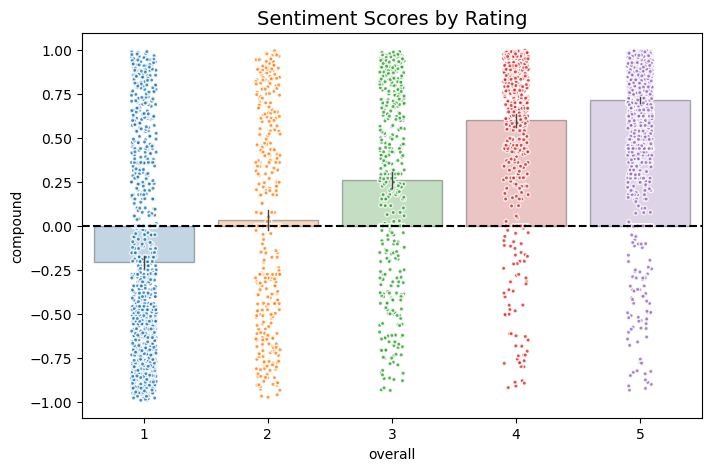

In [250]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 5))
sns.barplot(data=df_sentiment, x='overall', y='compound', hue='overall', palette=palette_tab10,ax=ax, 
              legend=False, alpha=0.3, edgecolor='black', linewidth=1, zorder=0, err_kws={'linewidth': 1,}
              )
sns.stripplot(data=df_sentiment, x='overall', y='compound', hue='overall', palette=palette_tab10,ax=ax, 
              legend=False,alpha=0.8, edgecolor='white', linewidth=1, size=3, zorder=0,)
ax.set_title("Sentiment Scores by Rating", fontsize=14)
ax.axhline(0, color='black', linestyle='--')
fig.savefig(FPATHS['eda']['sentiment']['sentiment-rating-strip_png'], transparent=False, bbox_inches='tight', dpi=300)

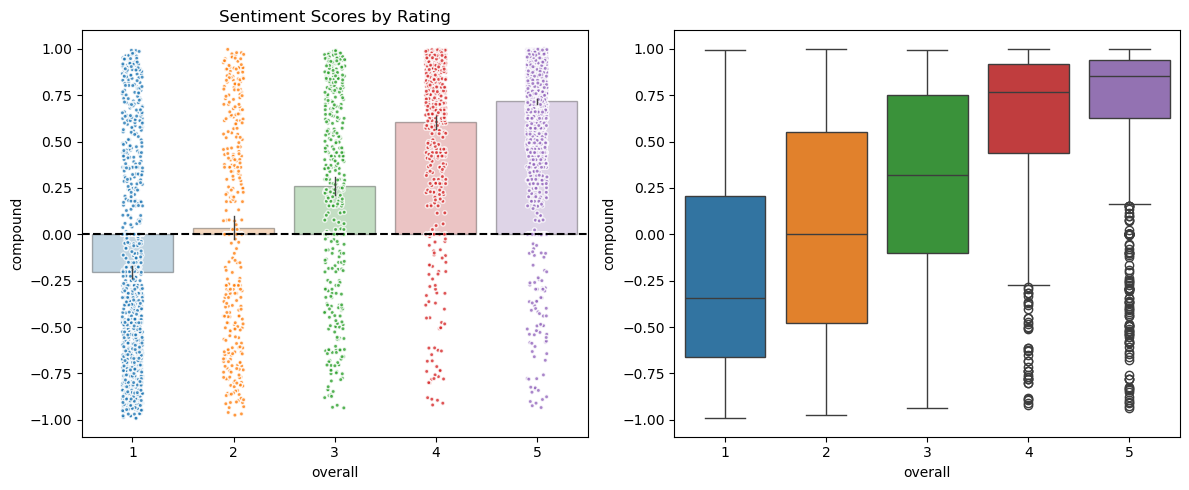

In [251]:
# Exclude from final README
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
sns.barplot(data=df_sentiment, x='overall', y='compound', hue='overall', palette=palette_tab10,ax=axes[0], 
              legend=False, alpha=0.3, edgecolor='black', linewidth=1, zorder=0, err_kws={'linewidth': 1,})
sns.stripplot(data=df_sentiment, x='overall', y='compound', hue='overall', palette=palette_tab10,ax=axes[0], 
              legend=False,alpha=0.8, edgecolor='white', linewidth=1, size=3, zorder=0,)
axes[0].set_title("Sentiment Scores by Rating")
axes[0].axhline(0, color='black', linestyle='--')
sns.boxplot(data=df_sentiment, x='overall', y='compound', hue='overall', palette=palette_tab10, ax=axes[1], legend=False)
fig.tight_layout()

### Sentiment Scores -  by Group

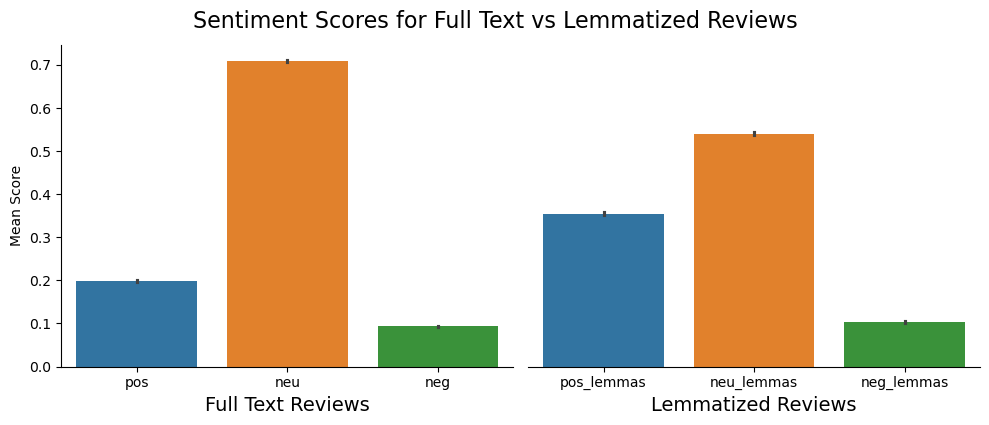

In [252]:
# Save lists of columns for easy access
sentment_cols = ['compound','pos','neu','neg']
sentiment_cols_lemmas = [f"{c}_lemmas" for c in sentment_cols]


fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

# Plot the sentiment scores for full text reviews
ax=axes[0]
sns.barplot(data=df_sentiment[sentment_cols].drop(columns=['compound']), errorbar=('ci',68),ax=ax)
ax.set_xlabel("Full Text Reviews", fontsize=14)
ax.set(#xlabel="Sentiment Score",
       ylabel="Mean Score"
       )



# Plot the sentiment scores for full text reviews
ax =axes[1]
sns.barplot(data=df_sentiment[sentiment_cols_lemmas].drop(columns=['compound_lemmas']), errorbar=('ci',68),
            ax=axes[1])
ax.set_xlabel("Lemmatized Reviews", fontsize=14)#, fontsize=16)
ax.set(#xlabel="Sentiment Score", 
       ylabel="Mean Score"
       )


## Remove spines
for ax in axes:
    for direction in ['top','right']:
        ax.spines[direction].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].yaxis.set_visible(False)

fig.tight_layout()
fig.suptitle("Sentiment Scores for Full Text vs Lemmatized Reviews", fontsize=16,y=1.05)

fig.savefig(FPATHS['eda']['sentiment']['sentiment-groups-bar_png'], transparent=False, bbox_inches='tight', dpi=300)

> Its intereesting that the lemmatized text shows reduced neutral sentiment and increased positive sentiment. 

In [253]:
df_sentiment.columns

Index(['asin', 'reviewerID', 'reviewText', 'summary', 'overall', 'year',
       'title', 'brand', 'category', 'review-text-full',
       'review-text-full_raw', 'tokens-dirty', 'tokens', 'lemmas',
       'tokens-dirty-joined', 'tokens-joined', 'lemmas-joined',
       'target-rating', 'neg', 'neu', 'pos', 'compound', 'neg_lemmas',
       'neu_lemmas', 'pos_lemmas', 'compound_lemmas'],
      dtype='object')

In [254]:
# Melt the sentiment scores to plot average compoud score
plot_df = pd.melt(df_sentiment, id_vars=['target-rating'], value_vars=['compound','compound_lemmas'], var_name='text_type', value_name='compound_score')
plot_df['text_type'] = plot_df['text_type'].replace(({'compound':'Full Text','compound_lemmas':'Lemmatized'}))
plot_df

,target-rating,text_type,compound_score
0,None,Full Text,0.4295
1,None,Full Text,-0.1594
2,High,Full Text,0.1513
3,High,Full Text,0.8936
4,High,Full Text,0.3612
...,...,...,...
8721,Low,Lemmatized,0.0000
8722,High,Lemmatized,0.0000
8723,Low,Lemmatized,-0.5574
8724,Low,Lemmatized,-0.6486


In [255]:
FPATHS['eda']['sentiment']['sentiment-overall-bar_png']

'eda/sentiment-overall-bar.png'

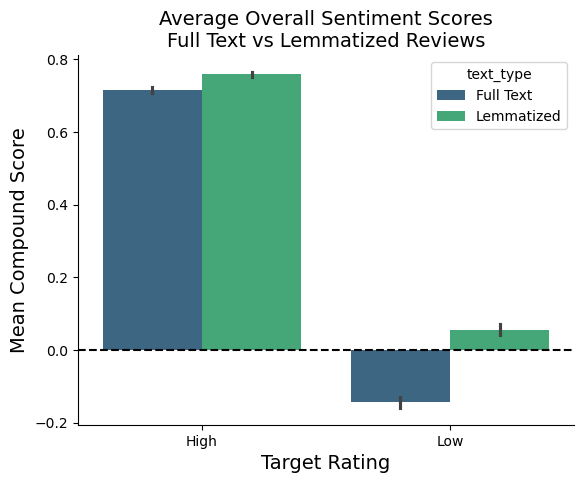

In [256]:
# Plot the average compound scores for full text and lemmatized reviews
ax = sns.barplot(data=plot_df, x='target-rating', y='compound_score', hue='text_type', errorbar=('ci',68),
                 palette='viridis')
ax.axhline(0, color='black', linestyle='--');
ax.set_xlabel("Target Rating", fontsize=14)
ax.set_ylabel("Mean Compound Score", fontsize=14)
ax.set_title("Average Overall Sentiment Scores\nFull Text vs Lemmatized Reviews", fontsize=14)
for direction in ['top','right']:
    ax.spines[direction].set_visible(False)
fig = ax.get_figure()

fig.savefig(FPATHS['eda']['sentiment']['sentiment-overall-bar_png'], transparent=False, bbox_inches='tight', dpi=300)    


> Its also interesting to see here that the low-rating reviews lose their overeall negatiivity following lemmatization.

### Correlations

> Not currently saved for README/app

<Axes: >

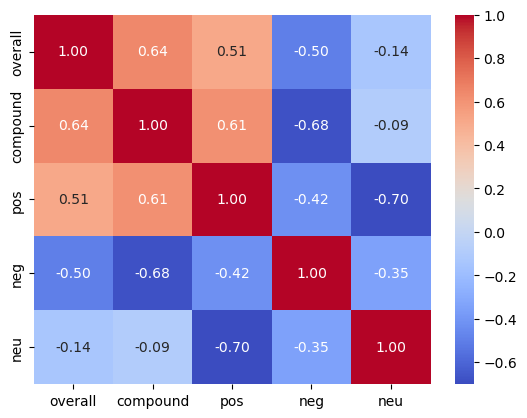

In [257]:
sentment_cols = ['compound','pos','neg','neu']
sns.heatmap(df_sentiment[['overall',*sentment_cols]].corr(), cmap='coolwarm', annot=True, fmt=".2f")

<Axes: >

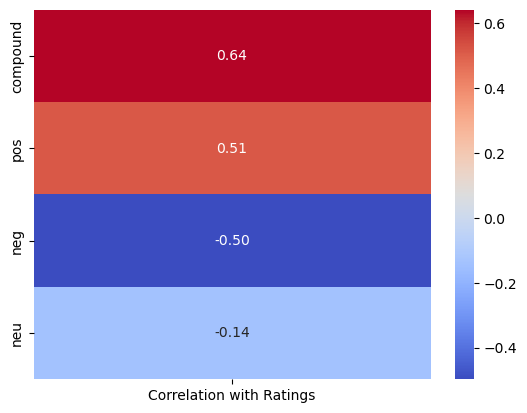

In [258]:
sns.heatmap(df_sentiment[sentment_cols].corrwith(df_sentiment['overall']).to_frame('Correlation with Ratings'),
            cmap='coolwarm', annot=True, fmt=".2f")

## Sentiment - HuggingFace Pipelines [`WIP`]
- Must resolve tf_keras error.

In [259]:
# !pip install transformers

In [260]:
# # conda install tensorflow-mac tensorflow-metal
# !pip install tensorflow-macos#"<=2.13.1"
# !pip install tensorflow-metal

In [261]:
import tensorflow as tf

In [262]:
# dir(google)

In [263]:
# !pip install tensorflow-macos
# !pip install tensorflow-metal
# !pip install -U protobuf #==3.19.4
# # !pip install tf-keras

In [264]:
# !pip install -U torch torchvision torchaudio
# !pip install transformers

In [265]:
import tensorflow as tf


In [266]:
from transformers import pipeline
model = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_analyzer = pipeline(task="sentiment-analysis",model=model)

RuntimeError: Failed to import transformers.models.distilbert.modeling_tf_distilbert because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [ ]:
sentiment_analyzer("I think i enjoy it when I am being beat up")

In [ ]:
df['review-text-full'].isna().sum()

In [ ]:
test_text = df.loc[0,'review-text-full']
test_text

In [ ]:
sentiment_analyzer(test_text)

In [ ]:
sentiment_results = []
for i in df.index:
    text = df.loc[i, 'review-text-full']
    try:
        sent = sentiment_analyzer(text)[0]
        
    except Exception as e:
        display(e)
        sent = {'label':pd.NA,'score':pd.NA}
    finally:
        sentiment_results.append(sent)
        

# sentiment_results = df['review-text-full'].map(lambda x: sentiment_analyzer(x))
len(sentiment_results)

In [ ]:
pd.DataFrame(sentiment_results)